In [1]:
#Simulated Generic Cache
# Libraries
import sys
import pandas as pd
import math
import numpy as np
from numpy import nan as Nan
import matplotlib.pyplot as plt
from random import randrange
import array
#from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [2]:
class Request:
    def __init__(self, name, interval, jitter, burstiness):
        self.name = name
        self.interval = interval
        self.burstiness = burstiness
        self.jitter = jitter
        if self.jitter > 0:
            self.active = interval + randrange(jitter)
        else:
            self.active = interval
    
    def send(self, step):
        if (step % self.active == 0):
            if self.jitter > 0:
                self.active = self.interval + randrange(self.jitter)
            else:
                self.active = self.interval
            return self.burstiness
        else:
            return 0
    
        

def CreateIngress(amount):
    IngressQueue = []
    #Paced Request Intervals
    Requests = []
    Requests.append(Request("A", 5, 0, 2))  # Name, Interval between bursts, jitter amount, burst amount
    Requests.append(Request("B", 2, 10, 1))
    Requests.append(Request("C", 12, 4, 6))
    
    for a in range(amount):
        for req in Requests:
            burst = req.send(a)
            while burst > 0:
                IngressQueue.append(req.name)
                burst = burst - 1
        if len(IngressQueue) < a+1:
            IngressQueue.append("X") #if nothing has been send for this timestep, add ""
    
    for b in range(amount):
        IngressQueue.append("X")
    
    return IngressQueue


In [3]:
IQ = CreateIngress(100)
print(IQ)

['A', 'A', 'B', 'C', 'C', 'C', 'C', 'C', 'C', 'A', 'A', 'A', 'A', 'B', 'B', 'C', 'C', 'C', 'C', 'C', 'C', 'A', 'A', 'B', 'A', 'A', 'B', 'B', 'C', 'C', 'C', 'C', 'C', 'C', 'A', 'A', 'B', 'C', 'C', 'C', 'C', 'C', 'C', 'A', 'A', 'B', 'B', 'A', 'A', 'A', 'A', 'B', 'C', 'C', 'C', 'C', 'C', 'C', 'B', 'A', 'A', 'B', 'A', 'A', 'B', 'C', 'C', 'C', 'C', 'C', 'C', 'B', 'A', 'A', 'B', 'A', 'A', 'B', 'B', 'A', 'A', 'C', 'C', 'C', 'C', 'C', 'C', 'B', 'A', 'A', 'B', 'A', 'A', 'B', 'C', 'C', 'C', 'C', 'C', 'C', 'A', 'A', 'B', 'B', 'C', 'C', 'C', 'C', 'C', 'C', 'A', 'A', 'B', 'B', 'B', 'A', 'A', 'B', 'A', 'A', 'B', 'C', 'C', 'C', 'C', 'C', 'C', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X',

In [4]:
class Cache:
    def __init__(self, size):
        self.size = size
        self.item = []
        self.metric = []
        
    def load(self, load_item, load_metric):
        if (len(self.metric) == self.size):
            evict = self.metric.index(min(self.metric))
            del self.metric[evict]
            del self.item[evict]
        self.metric.append(load_metric)
        self.item.append(load_item)
    
    

In [5]:
def LRU_Service(IQ, cachesize, fetch_time):
    cache = Cache(cachesize)
    result = []     # how many timesteps it took to serve a requests
    waiting = {}    # Request Pairs = Time : Type
    fetch_request = {}      # Request Pairs = Type : Time_Arrive
    ts = 0          # timestep
    
    for ingress in IQ:
        # Update Cache if a Fetch has completed
        del_fetches = []
        for fetch_type in fetch_request:
            if (fetch_request[fetch_type] + fetch_time == ts):
                # print("---Fetched: " + fetch_type )
                cache.load(fetch_type, ts)
                del_fetches.append(fetch_type)
        for x in del_fetches:
            del fetch_request[x]

        #print("Time: " + str(ts) )
        #print("-Arrived: " + ingress)
        
        # Can we serve any requests? Check our waiting pool
        if (ingress != "X"):
            waiting.update({ ts:ingress })    # A new request has arrived!
        del_waits = []
        for received in waiting:  
            result_type = waiting[received]
            if result_type in cache.item:
                cache.metric[cache.item.index(result_type)] = ts
                result.append(ts - received)
                del_waits.append(received)
            else:  
                if  result_type not in fetch_request:
                    # print("--Requested: " + result_type)
                    fetch_request.update({result_type : ts+fetch_time})
        for x in del_waits:
            del waiting[x]
        ts = ts + 1
        
        #print("Waiting: " + str(waiting))
        
    return result

In [6]:
def BeladyAD_Service(IQ, cachesize, fetch_time):
    cache = Cache(cachesize)
    result = []     # how many timesteps it took to serve a requests
    waiting = {}    # Request Pairs = Time : Type
    fetch_request = {}      # Request Pairs = Type : Time_Arrive
    ts = 0          # timestep
    
    
    
    for ingress in IQ:
        # Belady Metric Update
        if ts > 20:
            for r in range(20):
                for c in cache.item:
                    if IQ[ts-r] == c:
                        cache.metric[cache.item.index(c)] = r * -1
        
        # Update Cache if a Fetch has completed
        del_fetches = []
        for fetch_type in fetch_request:
            if (fetch_request[fetch_type] + fetch_time == ts):
                # print("---Fetched: " + fetch_type )
                cache.load(fetch_type, ts)
                del_fetches.append(fetch_type)
        for x in del_fetches:
            del fetch_request[x]

        #print("Time: " + str(ts) )
        #print("-Arrived: " + ingress)
        
        # Can we serve any requests? Check our waiting pool
        if (ingress != "X"):
            waiting.update({ ts:ingress })    # A new request has arrived!
        del_waits = []
        for received in waiting:  
            result_type = waiting[received]
            if result_type in cache.item:
                result.append(ts - received)
                del_waits.append(received)
            else:  
                if  result_type not in fetch_request:
                    # print("--Requested: " + result_type)
                    fetch_request.update({result_type : ts+fetch_time})
        for x in del_waits:
            del waiting[x]
        ts = ts + 1
        
        #print("Waiting: " + str(waiting))
        
    return result

In [7]:
class MADmeta:
    def __init__(self, Z):
        self.num_windows = 0
        self.cum_delay = 0
        self.win_start = -1000
        self.Z = Z

    def aggDelay(self):
        return self.cum_delay/self.win_start
    
    def access(self, t):
        TSSW = t - self.win_start
        
        if TSSW >= self.Z:
            self.num_windows = self.num_windows + 1
            self.cum_delay = self.cum_delay + self.Z
            self.win_start = t
        else:
            self.cum_delay = self.cum_delay + (self.Z - TSSW)
        
    

def MAD_Service(IQ, cachesize, fetch_time):
    cache = Cache(cachesize)
    result = []     # how many timesteps it took to serve a requests
    waiting = {}    # Request Pairs = Time : Type
    fetch_request = {}      # Request Pairs = Type : Time_Arrive
    ts = 0          # timestep
    MAD_Data = {"A" : MADmeta(fetch_time), "B" : MADmeta(fetch_time), "C" : MADmeta(fetch_time)}
    
    
    for ingress in IQ:
        # MAD Metric Update
        if ts > 20:
            for r in range(20):
                for c in cache.item:
                    if IQ[ts-r] == c:
                        TTNA = r
                        cache.metric[cache.item.index(c)] = MAD_Data.get(c).aggDelay()
                        
        
        # Update Cache if a Fetch has completed
        del_fetches = []
        for fetch_type in fetch_request:
            if (fetch_request[fetch_type] + fetch_time == ts):
                # print("---Fetched: " + fetch_type )
                cache.load(fetch_type, ts)
                del_fetches.append(fetch_type)
        for x in del_fetches:
            del fetch_request[x]

        #print("Time: " + str(ts) )
        #print("-Arrived: " + ingress)
        
        # Can we serve any requests? Check our waiting pool
        if (ingress != "X"):
            waiting.update({ ts:ingress })    # A new request has arrived!
            MAD_Data.get(ingress).access(ts)
        del_waits = []
        for received in waiting:  
            result_type = waiting[received]
            if result_type in cache.item:
                result.append(ts - received)
                del_waits.append(received)
            else:  
                if  result_type not in fetch_request:
                    # print("--Requested: " + result_type)
                    fetch_request.update({result_type : ts+fetch_time})
        for x in del_waits:
            del waiting[x]
        ts = ts + 1
        
        #print("Waiting: " + str(waiting))
        
    return result

In [8]:
#Test Run
IQ = CreateIngress(1000)
c_size = 2
z = 10
LRU_result = LRU_Service(IQ, c_size, z)
BeladyAD_result = BeladyAD_Service(IQ, c_size, z)
MAD_result = MAD_Service(IQ, c_size, z)
#print(LRU_result)
#print(BeladyAD_result)
#print(MAD_result)
print("LRU Avg Latency: " + str(sum(LRU_result)/len(LRU_result)))
print("BeladyAD Avg Latency: " + str(sum(BeladyAD_result)/len(BeladyAD_result)))
print("MAD Avg Latency: " + str(sum(MAD_result)/len(MAD_result)))


LRU Avg Latency: 3.9191842900302114
BeladyAD Avg Latency: 3.623867069486405
MAD Avg Latency: 3.11178247734139


In [9]:
# Full Report
z_index = []
LRU_results = []
BeladyAD_results = []
MAD_results = []
MAD_ratio = []
BeladyAD_ratio = []

# Change delay and record for Z = 2^x
for i in range(12):
    z = 2 ** (i+1)
    z_index.append(z)
    c_size = 2
    IQ = CreateIngress(10000)
    
    LRU_trial = LRU_Service(IQ, c_size, z)
    BeladyAD_trial = BeladyAD_Service(IQ, c_size, z)
    MAD_trial = MAD_Service(IQ, c_size, z)
    
    LRU_avg = (sum(LRU_trial)/len(LRU_trial))
    BeladyAD_avg = (sum(BeladyAD_trial)/len(BeladyAD_trial))
    MAD_avg = (sum(MAD_trial)/len(MAD_trial))
    
    LRU_results.append(LRU_avg)
    BeladyAD_results.append(BeladyAD_avg)
    MAD_results.append(MAD_avg)
    
    MAD_ratio.append(LRU_avg/MAD_avg)
    BeladyAD_ratio.append(LRU_avg/BeladyAD_avg)


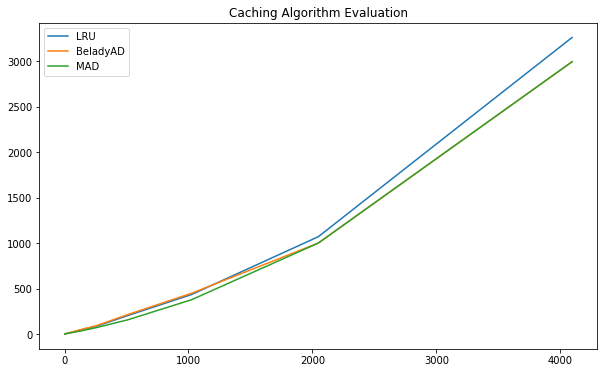

In [13]:
d = {'LRU': LRU_results, 'BeladyAD': BeladyAD_results, 'MAD': MAD_results}
df = pd.DataFrame(data=d, index=z_index)

plotA = df[['LRU', 'BeladyAD', 'MAD']].plot(kind='line', title='Caching Algorithm Evaluation', figsize=[10,6])


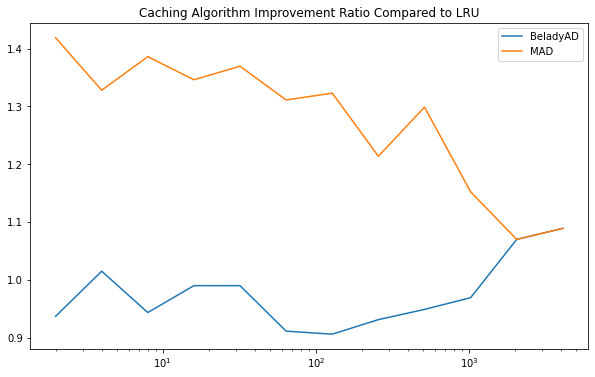

In [14]:
dB = {'BeladyAD': BeladyAD_ratio, 'MAD': MAD_ratio}
dfB = pd.DataFrame(data=dB, index=z_index)


plotB = dfB[['BeladyAD', 'MAD']].plot(kind='line', title='Caching Algorithm Improvement Ratio Compared to LRU', logx=True, figsize=[10,6])
plt.show()